<a href="https://colab.research.google.com/github/oakthyago/PDF-Data-Extraction/blob/main/Notas_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.0 MB/s eta 0:00:00


**This project focuses on extracting structured information from PDF files that contain tables, with the goal of transforming this data into a usable dataset. The process is made feasible due to the regular format of the tables across the PDF pages, where a predefined structure and positioning can be identified. Additionally, it's worth noting that the original data was likely sourced from databases, which contributes to the consistency in the format.**

In [2]:
import pdfplumber
import pandas as pd
import re
import os

def extrair_tabelas_pdf(caminho_pdf):
    with pdfplumber.open(caminho_pdf) as pdf:
        todas_tabelas = []
        dados_produtos_completo = ""

        # Expressão regular para capturar o bloco de 'DADOS DOS PRODUTOS / SERVIÇOS'
        padrao = r"DADOS DOS PRODUTOS / SERVIÇOS(.*?)(?=DADOS ADICIONAIS)"
        padrao_alternativo = r"DADOS DOS PRODUTOS / SERVIÇOS(.*)"

        # Itera sobre todas as páginas do PDF
        for numero_pagina, pagina in enumerate(pdf.pages, start=1):
            texto_pagina = pagina.extract_text()

            # Primeira tentativa: captura entre 'DADOS DOS PRODUTOS / SERVIÇOS' e 'DADOS ADICIONAIS'
            dados_produtos = re.search(padrao, texto_pagina, re.DOTALL)

            if dados_produtos:
                dados_produtos_completo += dados_produtos.group(0) + "\n"
            else:
                # Segunda tentativa: captura tudo depois de 'DADOS DOS PRODUTOS / SERVIÇOS' se 'DADOS ADICIONAIS' não for encontrado
                dados_produtos_fallback = re.search(padrao_alternativo, texto_pagina, re.DOTALL)

                if dados_produtos_fallback:
                    dados_produtos_completo += dados_produtos_fallback.group(0) + "\n"
                else:
                    print(f"Seção de dados do produto não encontrada na página {numero_pagina}.")

            # Agora, tenta extrair as tabelas da página dentro do bloco extraído
            if dados_produtos or dados_produtos_fallback:
                tabelas = pagina.extract_tables()

                # Se houver tabelas na página, adiciona à lista
                if tabelas:
                    for tabela in tabelas:
                        df = pd.DataFrame(tabela[1:], columns=tabela[0])  # Converte a tabela em DataFrame
                        todas_tabelas.append(df)

        return todas_tabelas, dados_produtos_completo

def processar_varios_pdfs(diretorio):
    resultados = {}

    # Itera sobre todos os arquivos PDF no diretório
    for arquivo in os.listdir(diretorio):
        if arquivo.endswith(".pdf"):
            caminho_pdf = os.path.join(diretorio, arquivo)
            tabelas, dados_textuais = extrair_tabelas_pdf(caminho_pdf)
            resultados[arquivo] = {
                "tabelas": tabelas,
                "dados_textuais": dados_textuais
            }

    return resultados

# Diretório onde as notas fiscais estão localizadas
diretorio_notas = '/content/drive/MyDrive/120/12'  # Substitua pelo caminho correto

# Processar todos os PDFs no diretório e obter os resultados
resultados = processar_varios_pdfs(diretorio_notas)

# Exibir os resultados para cada nota fiscal
for arquivo, conteudo in resultados.items():
    print(f"\nDados extraídos da nota {arquivo}:\n")

    # Exibir texto extraído
    print("Texto extraído:\n")
    print(conteudo["dados_textuais"])

    # Exibir tabelas extraídas
    for idx, tabela in enumerate(conteudo["tabelas"]):
        print(f"\nTabela {idx + 1}:\n")
        print(tabela)

A saída de streaming foi truncada nas últimas 5000 linhas.
0   500  6101  PAR  2,0000     56,3200        112,6             4 0,00 112,   
1   500  6101  PAR  2,0000     56,3200        112,6             4 0,00 112,   
2   500  6101  PAR  2,0000     56,3200        112,6             4 0,00 112,   
3   500  6101  PAR  2,0000     56,3200        112,6             4 0,00 112,   
4                                                                             

  VALOR VALOR AL\nICMS IPI IC ÍQ. ALÍQ.\nMS IPI  
0                  64 7,88 7,                00  
1                  64 7,88 7,                00  
2                  64 7,88 7,                00  
3                  64 7,88 7,                00  
4                                                

Tabela 27:

  IDENTIFICAÇÃO DO EMITENTE\nCALCADOS BEIRA RIO S/A\nRUA ARNALDO KRUG, 835\nCANABARRO - 95890-000\nTEUTONIA - RS Fone/Fax: 8130359808  \
0                                               None                                           

In [62]:
# Inicializa o DataFrame concatenado
df_concat = pd.DataFrame()

# Itera sobre as tabelas no conteúdo
for idx, tabela in enumerate(conteudo["tabelas"]):
    # Verifica se 'CÓDIGO PRODUTO' está nas colunas
    if 'CÓDIGO PRODUTO' in tabela.columns:
        # Encontra o índice da coluna 'CÓDIGO PRODUTO'
        idx_codigo_produto = tabela.columns.get_loc('CÓDIGO PRODUTO')

        # Define as próximas cinco colunas após 'CÓDIGO PRODUTO'
        colunas_desejadas = tabela.columns[idx_codigo_produto:idx_codigo_produto + 8]

        # Filtra as colunas desejadas
        df_filtered = tabela[colunas_desejadas]

        # Se for a primeira tabela, copia para o df_concat, caso contrário, concatena
        if idx == 0:
            df_concat = df_filtered.copy()
        else:
            df_concat = pd.concat([df_concat, df_filtered], ignore_index=True)

# Exibe o DataFrame concatenado
df_concat

,CÓDIGO PRODUTO,DESCRIÇÃO DO PRODUTO / SERVIÇO,NCM/SH,O/CST,CFOP,UN,QUANT,VALOR\nUNIT,VALO\nUNIT
0,24144389,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"1,0000","85,0900",NaN
1,24144391,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"2,0000","85,0900",NaN
2,24144393,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"3,0000","85,0900",NaN
3,,,,,,,,,NaN
4,24144395,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"3,0000",NaN,"85,0"
...,...,...,...,...,...,...,...,...,...
842,36300202598-33,BOTA KIDY STYLE AVELA 33,64029190,500,6101,PARES,"1,0000",NaN,"67,80"
843,36300202598-34,BOTA KIDY STYLE AVELA 34,64029190,500,6101,PARES,"2,0000",NaN,"67,80"
844,36300202598-35,BOTA KIDY STYLE AVELA 35,64029190,500,6101,PARES,"2,0000",NaN,"67,80"
845,36300202598-36,BOTA KIDY STYLE AVELA 36,64029190,500,6101,PARES,"2,0000",NaN,"67,80"


The strip() method is applied to each cell to generate a boolean matrix that identifies rows containing empty or whitespace-only strings (''). This matrix will be used to drop those rows from the dataset, ensuring that only meaningful data remains.

In [63]:
# Função para aplicar o strip e verificar se a célula está vazia
def is_empty(cell):
    return str(cell).strip() == ''

# Aplicar a função ao DataFrame usando applymap, que aplica a função a cada célula
boolean_matrix = df_concat.applymap(is_empty)

# Exibir a matriz booleana
boolean_matrix

<ipython-input-63-e1371913c4dc>:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  boolean_matrix = df_concat.applymap(is_empty)


,CÓDIGO PRODUTO,DESCRIÇÃO DO PRODUTO / SERVIÇO,NCM/SH,O/CST,CFOP,UN,QUANT,VALOR\nUNIT,VALO\nUNIT
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
842,False,False,False,False,False,False,False,False,False
843,False,False,False,False,False,False,False,False,False
844,False,False,False,False,False,False,False,False,False
845,False,False,False,False,False,False,False,False,False


In [64]:
# prompt: column boolean_matrix[CÓDIGO PRODUTO]  and then drop the line wicth is true in df_concat

# Seleciona a coluna 'CÓDIGO PRODUTO' da matriz booleana
codigo_produto_empty = boolean_matrix['CÓDIGO PRODUTO']

# Remove as linhas onde a coluna 'CÓDIGO PRODUTO' é True (indicando que a célula está vazia)
df_concat = df_concat[~codigo_produto_empty]


In [37]:
df_concat

,CÓDIGO PRODUTO,DESCRIÇÃO DO PRODUTO / SERVIÇO,NCM/SH,O/CST,CFOP,UN,QUANT,VALOR\nUNIT,VALO\nUNIT
0,24144389,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"1,0000","85,0900",NaN
1,24144391,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"2,0000","85,0900",NaN
2,24144393,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"3,0000","85,0900",NaN
4,24144395,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"3,0000",NaN,"85,0"
5,24144397,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,PAR,"2,0000",NaN,"85,0"
...,...,...,...,...,...,...,...,...,...
841,36300202598-32,BOTA KIDY STYLE AVELA 32,64029190,500,6101,PARES,"1,0000",NaN,"67,80"
842,36300202598-33,BOTA KIDY STYLE AVELA 33,64029190,500,6101,PARES,"1,0000",NaN,"67,80"
843,36300202598-34,BOTA KIDY STYLE AVELA 34,64029190,500,6101,PARES,"2,0000",NaN,"67,80"
844,36300202598-35,BOTA KIDY STYLE AVELA 35,64029190,500,6101,PARES,"2,0000",NaN,"67,80"


In [38]:
# prompt: df = df_concat

df = df_concat


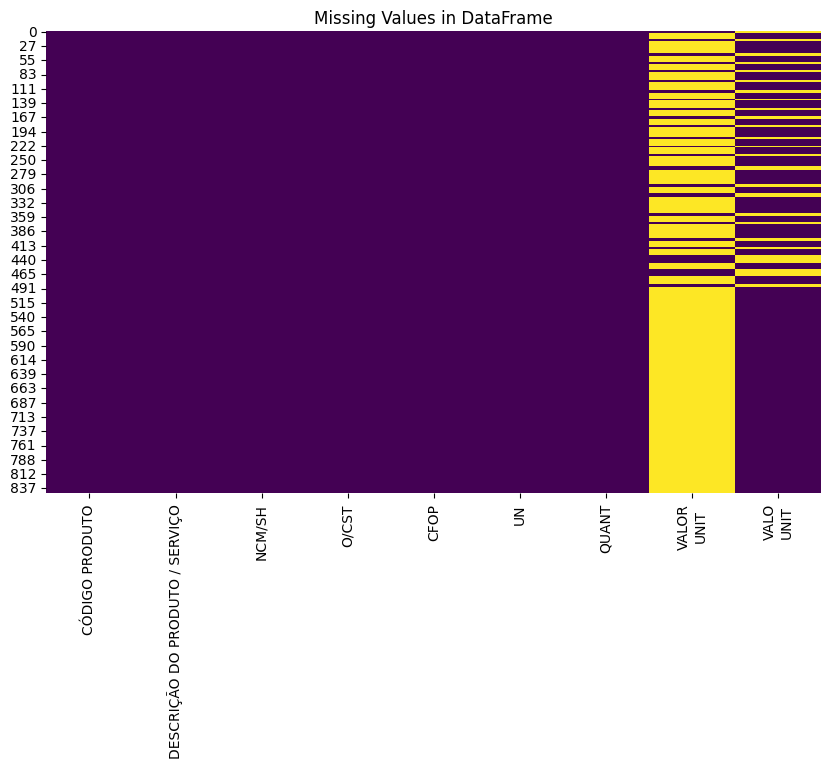

In [23]:
# prompt: df_concat seaborn plot of Nan on the df

import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df_concat.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in DataFrame')
plt.show()


Notice that on the process Valor Unit was split in two columns but can be reorganizaed


<ipython-input-69-cf8cf7215db2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat['Valor Unitário'] = df_concat['VALOR\nUNIT'].fillna(df_concat['VALO\nUNIT'])
<ipython-input-69-cf8cf7215db2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat['Valor Unitário'] = pd.to_numeric(df_concat['Valor Unitário'].str.replace(',', '.'), errors='coerce')


,CÓDIGO PRODUTO,DESCRIÇÃO DO PRODUTO / SERVIÇO,NCM/SH,O/CST,CFOP,UN,QUANT,VALOR\nUNIT,VALO\nUNIT,Valor Unitário
0,24144389,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,1,"1,0000","85,0900",NaN,85.09
1,24144391,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,2,"2,0000","85,0900",NaN,85.09
2,24144393,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,3,"3,0000","85,0900",NaN,85.09
4,24144395,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,3,"3,0000",NaN,"85,0",85.00
5,24144397,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,2,"2,0000",NaN,"85,0",85.00
...,...,...,...,...,...,...,...,...,...,...
841,36300202598-32,BOTA KIDY STYLE AVELA 32,64029190,500,6101,1,"1,0000",NaN,"67,80",67.80
842,36300202598-33,BOTA KIDY STYLE AVELA 33,64029190,500,6101,1,"1,0000",NaN,"67,80",67.80
843,36300202598-34,BOTA KIDY STYLE AVELA 34,64029190,500,6101,2,"2,0000",NaN,"67,80",67.80
844,36300202598-35,BOTA KIDY STYLE AVELA 35,64029190,500,6101,2,"2,0000",NaN,"67,80",67.80


In [65]:
df = df_concat

In [58]:
df_concat = df

In [66]:
# prompt: open df_concat['QUANT'] get the first char before ',' and save in new column "UN", its a objct AttributeError: Can only use .str accessor with string values!

# Convert the 'QUANT' column to strings
df_concat['QUANT'] = df_concat['QUANT'].astype(str)

# Extract the first character before the comma
df_concat['UN'] = df_concat['QUANT'].str.split(',').str[0]

# prompt: df_concat[VALOR\nUNIT 	VALO\nUNIT]  should be in a same new column and this column should have a flot vareble format to be use in excel in the future

# Combine 'VALOR\nUNIT' and 'VALO\nUNIT' columns into a new column 'Valor Unitário'
df_concat['Valor Unitário'] = df_concat['VALOR\nUNIT'].fillna(df_concat['VALO\nUNIT'])

# Remove the original columns


# Convert the new column to float
df_concat['Valor Unitário'] = pd.to_numeric(df_concat['Valor Unitário'].str.replace(',', '.'), errors='coerce')
df_concat


<ipython-input-66-37d8e1915e86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat['QUANT'] = df_concat['QUANT'].astype(str)
<ipython-input-66-37d8e1915e86>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat['UN'] = df_concat['QUANT'].str.split(',').str[0]


In [70]:
df_concat

,CÓDIGO PRODUTO,DESCRIÇÃO DO PRODUTO / SERVIÇO,NCM/SH,O/CST,CFOP,UN,QUANT,VALOR\nUNIT,VALO\nUNIT,Valor Unitário
0,24144389,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,1,"1,0000","85,0900",NaN,85.09
1,24144391,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,2,"2,0000","85,0900",NaN,85.09
2,24144393,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,3,"3,0000","85,0900",NaN,85.09
4,24144395,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,3,"3,0000",NaN,"85,0",85.00
5,24144397,SAPATO CASUAL MASC. DE USO COMUM C/\nSOLA SINT...,64041900,500,6101,2,"2,0000",NaN,"85,0",85.00
...,...,...,...,...,...,...,...,...,...,...
841,36300202598-32,BOTA KIDY STYLE AVELA 32,64029190,500,6101,1,"1,0000",NaN,"67,80",67.80
842,36300202598-33,BOTA KIDY STYLE AVELA 33,64029190,500,6101,1,"1,0000",NaN,"67,80",67.80
843,36300202598-34,BOTA KIDY STYLE AVELA 34,64029190,500,6101,2,"2,0000",NaN,"67,80",67.80
844,36300202598-35,BOTA KIDY STYLE AVELA 35,64029190,500,6101,2,"2,0000",NaN,"67,80",67.80


In [73]:
# prompt: gets only the values that is a number on df_concat ["UN"] and transform it in int

# Filter the 'UN' column to keep only numeric values
df_concat['UN'] = df_concat['UN'][df_concat['UN'].str.isdigit()]

# Convert the 'UN' column to integers
df_concat['UN'] = df_concat['UN'].fillna(0).astype(int)


AttributeError: Can only use .str accessor with string values!

In [76]:
# prompt: df_concat["UN"] * df_concat["Valor Unitário"] new colum valor total

df_concat["Valor Total"] = df_concat["UN"] * df_concat["Valor Unitário"]


<ipython-input-76-bef7ddf949d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat["Valor Total"] = df_concat["UN"] * df_concat["Valor Unitário"]


In [79]:
# prompt: sum(df["Valor total]

df_concat["Valor Total"].sum()


76175.38